In [50]:
import numpy as np
import matplotlib.pyplot as plt


In [51]:
# Parameters (aligned with DP.ipynb)
lam = 0.4  # lambda
mu = 0.25  # mu
rho = 0.1  # discount factor, lam + 2*mu + rho = 1
cost = 0.001  # technological cost
a = 0.9  # fault probability
p1 = 0.1
p2 = 0.9
theta = 0.001  # converge threshold
maxLength = 32

np.random.seed(0)


In [52]:
def solve_dp(lam, mu, cost, a, p1, p2, theta, maxLength):
    value = np.zeros((maxLength + 1, maxLength + 1))
    policy = np.zeros((maxLength + 1, maxLength + 1))
    outer_iters = 0
    inner_iters = 0
    delta_hist = []
    while True:
        # Policy evaluation
        while True:
            delta = 0.0
            inner_iters += 1
            val = value.copy()
            for x in range(maxLength + 1):
                for y in range(maxLength + 1):
                    v = value[x, y]
                    b = policy[x, y]
                    xx = min(x + 1, maxLength)
                    yy = min(y + 1, maxLength)
                    if xx == x or yy == y:
                        next_term = max(val[xx, y], val[x, yy])
                    else:
                        next_term = min(val[xx, y], val[x, yy])
                    value[x, y] = (
                        x + y + cost * b
                        + mu * (val[max(x - 1, 0), y] + val[x, max(y - 1, 0)])
                        + (1 - (1 - b) * a) * lam * next_term
                        + p1 * (1 - b) * a * lam * val[xx, y]
                        + p2 * (1 - b) * a * lam * val[x, yy]
                    )
                    delta = max(delta, abs(v - value[x, y]))
            delta_hist.append(delta)
            if delta < theta:
                break

        # Policy improvement
        stable = True
        for x in range(maxLength + 1):
            for y in range(maxLength + 1):
                old = policy[x, y]
                xx = min(x + 1, maxLength)
                yy = min(y + 1, maxLength)
                diff = a * lam * (p1 * value[xx, y] + p2 * value[x, yy] - min(value[xx, y], value[x, yy]))
                if diff <= cost:
                    policy[x, y] = 0
                else:
                    policy[x, y] = 1
                if old != policy[x, y]:
                    stable = False

        outer_iters += 1
        if stable:
            break

    return value, policy, outer_iters, inner_iters, delta_hist

value, policy, outer_iters, inner_iters, delta_hist = solve_dp(lam, mu, cost, a, p1, p2, theta, maxLength)
print(f"DP converged in {outer_iters} outer iterations")
print(f"DP inner iterations: {inner_iters}")
print(f"DP delta history length: {len(delta_hist)}")


DP converged in 6 outer iterations
DP inner iterations: 176
DP delta history length: 176


In [53]:
def q_from_value(x, y, b, V):
    xx = min(x + 1, maxLength)
    yy = min(y + 1, maxLength)
    if xx == x or yy == y:
        next_term = max(V[xx, y], V[x, yy])
    else:
        next_term = min(V[xx, y], V[x, yy])
    return (
        x + y + cost * b
        + mu * (V[max(x - 1, 0), y] + V[x, max(y - 1, 0)])
        + (1 - (1 - b) * a) * lam * next_term
        + p1 * (1 - b) * a * lam * V[xx, y]
        + p2 * (1 - b) * a * lam * V[x, yy]
    )

q_table = np.zeros((maxLength + 1, maxLength + 1, 2))
for x in range(maxLength + 1):
    for y in range(maxLength + 1):
        for b in (0, 1):
            q_table[x, y, b] = q_from_value(x, y, b, value)


In [54]:
# Build training data for NNQ: (x, y, b) -> Q(x, y, b)
xs = np.arange(maxLength + 1)
ys = np.arange(maxLength + 1)

X_list = []
Y_list = []
for x in xs:
    for y in ys:
        for b in (0, 1):
            X_list.append([x / maxLength, y / maxLength, float(b)])
            Y_list.append(q_table[x, y, b])

X = np.array(X_list, dtype=float)
Y = np.array(Y_list, dtype=float).reshape(-1, 1)

# Shuffle once for a stable split
perm = np.random.permutation(len(X))
X = X[perm]
Y = Y[perm]


In [55]:
class MLPQ:
    def __init__(self, input_dim=3, h1=64, h2=32, seed=0):
        rng = np.random.default_rng(seed)
        self.W1 = rng.normal(scale=0.1, size=(input_dim, h1))
        self.b1 = np.zeros((1, h1))
        self.W2 = rng.normal(scale=0.1, size=(h1, h2))
        self.b2 = np.zeros((1, h2))
        self.W3 = rng.normal(scale=0.1, size=(h2, 1))
        self.b3 = np.zeros((1, 1))

        # Adam moments
        self.m = [np.zeros_like(self.W1), np.zeros_like(self.b1),
                  np.zeros_like(self.W2), np.zeros_like(self.b2),
                  np.zeros_like(self.W3), np.zeros_like(self.b3)]
        self.v = [np.zeros_like(self.W1), np.zeros_like(self.b1),
                  np.zeros_like(self.W2), np.zeros_like(self.b2),
                  np.zeros_like(self.W3), np.zeros_like(self.b3)]
        self.t = 0

    def forward(self, Xb):
        Z1 = Xb @ self.W1 + self.b1
        H1 = np.maximum(0.0, Z1)
        Z2 = H1 @ self.W2 + self.b2
        H2 = np.maximum(0.0, Z2)
        Yp = H2 @ self.W3 + self.b3
        cache = (Xb, Z1, H1, Z2, H2)
        return Yp, cache


    def params_vector(self):
        return np.concatenate([
            self.W1.ravel(), self.b1.ravel(),
            self.W2.ravel(), self.b2.ravel(),
            self.W3.ravel(), self.b3.ravel(),
        ])

    def predict(self, Xb):
        Yp, _ = self.forward(Xb)
        return Yp

    def step(self, Xb, Yb, lr=1e-3, beta1=0.9, beta2=0.999, eps=1e-8):
        self.t += 1
        Yp, (Xb, Z1, H1, Z2, H2) = self.forward(Xb)
        dY = 2.0 * (Yp - Yb) / len(Xb)

        grad_W3 = H2.T @ dY
        grad_b3 = dY.sum(axis=0, keepdims=True)
        dH2 = dY @ self.W3.T
        dZ2 = dH2 * (Z2 > 0)
        grad_W2 = H1.T @ dZ2
        grad_b2 = dZ2.sum(axis=0, keepdims=True)
        dH1 = dZ2 @ self.W2.T
        dZ1 = dH1 * (Z1 > 0)
        grad_W1 = Xb.T @ dZ1
        grad_b1 = dZ1.sum(axis=0, keepdims=True)

        grads = [grad_W1, grad_b1, grad_W2, grad_b2, grad_W3, grad_b3]
        params = [self.W1, self.b1, self.W2, self.b2, self.W3, self.b3]

        for i in range(len(params)):
            self.m[i] = beta1 * self.m[i] + (1 - beta1) * grads[i]
            self.v[i] = beta2 * self.v[i] + (1 - beta2) * (grads[i] ** 2)
            m_hat = self.m[i] / (1 - beta1 ** self.t)
            v_hat = self.v[i] / (1 - beta2 ** self.t)
            params[i] -= lr * m_hat / (np.sqrt(v_hat) + eps)

        loss = float(np.mean((Yp - Yb) ** 2))
        return loss

model = MLPQ(input_dim=3, h1=64, h2=32, seed=0)

# Training
epochs = 2000
batch_size = 256
loss_history = []
param_history = []

for epoch in range(1, epochs + 1):
    perm = np.random.permutation(len(X))
    Xs = X[perm]
    Ys = Y[perm]
    for i in range(0, len(Xs), batch_size):
        xb = Xs[i:i + batch_size]
        yb = Ys[i:i + batch_size]
        loss = model.step(xb, yb, lr=1e-3)
    loss_history.append(loss)
    param_history.append(model.params_vector().copy())
    if epoch % 200 == 0:
        print(f"epoch {epoch}: mse={loss:.6f}")


epoch 200: mse=121.189295
epoch 400: mse=1.840394
epoch 600: mse=2.843341
epoch 800: mse=3.856322
epoch 1000: mse=2.966572
epoch 1200: mse=2.904019
epoch 1400: mse=2.440136
epoch 1600: mse=3.402528
epoch 1800: mse=1.364706
epoch 2000: mse=0.864812


Final MSE: 1.320124
Max abs error: 10.699257
Policy match ratio: 0.8255


C:\Users\asus\AppData\Local\Temp\ipykernel_68044\2759655212.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  q0_nn[x, y] = model.predict(x0)
C:\Users\asus\AppData\Local\Temp\ipykernel_68044\2759655212.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  q1_nn[x, y] = model.predict(x1)


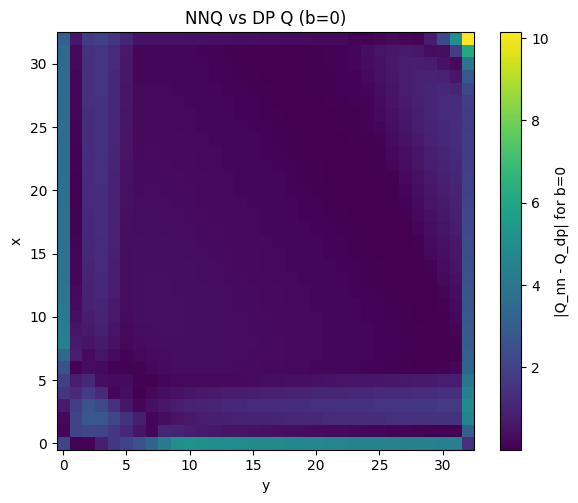

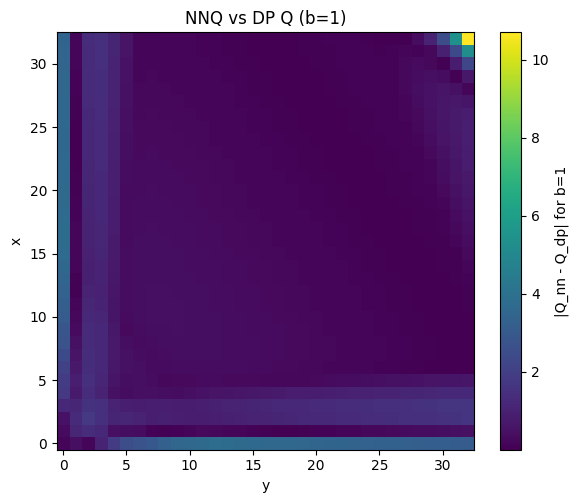

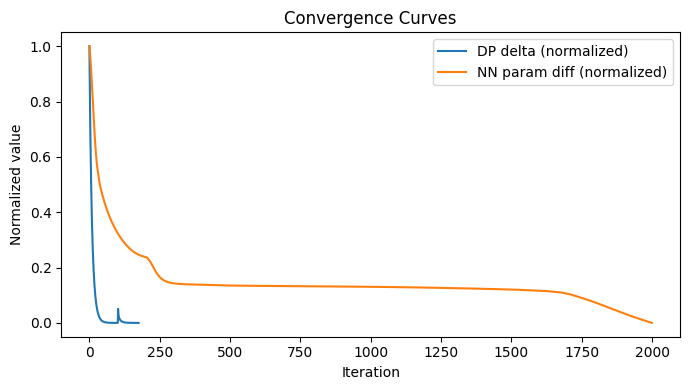

In [56]:
# Evaluation: compare NNQ with DP Q table
preds = model.predict(X).reshape(-1)
targets = Y.reshape(-1)

mse = float(np.mean((preds - targets) ** 2))
max_abs = float(np.max(np.abs(preds - targets)))
print(f"Final MSE: {mse:.6f}")
print(f"Max abs error: {max_abs:.6f}")

# Policy agreement: choose b with smaller Q (cost minimization)
q0 = q_table[:, :, 0]
q1 = q_table[:, :, 1]
policy_dp = (q1 < q0).astype(int)

# NN policy
q0_nn = np.zeros_like(q0)
q1_nn = np.zeros_like(q1)
for x in range(maxLength + 1):
    for y in range(maxLength + 1):
        x0 = np.array([[x / maxLength, y / maxLength, 0.0]])
        x1 = np.array([[x / maxLength, y / maxLength, 1.0]])
        q0_nn[x, y] = model.predict(x0)
        q1_nn[x, y] = model.predict(x1)

policy_nn = (q1_nn < q0_nn).astype(int)
policy_match = float(np.mean(policy_nn == policy_dp))
print(f"Policy match ratio: {policy_match:.4f}")

# Optional: visualize error heatmap for b=0
err_map = np.abs(q0_nn - q0)
plt.figure(figsize=(6, 5))
plt.imshow(err_map, origin='lower', cmap='viridis')
plt.colorbar(label='|Q_nn - Q_dp| for b=0')
plt.xlabel('y')
plt.ylabel('x')
plt.title('NNQ vs DP Q (b=0)')
plt.tight_layout()
plt.show()

# Optional: visualize error heatmap for b=1
err_map_b1 = np.abs(q1_nn - q1)
plt.figure(figsize=(6, 5))
plt.imshow(err_map_b1, origin='lower', cmap='viridis')
plt.colorbar(label='|Q_nn - Q_dp| for b=1')
plt.xlabel('y')
plt.ylabel('x')
plt.title('NNQ vs DP Q (b=1)')
plt.tight_layout()
plt.show()



# Convergence comparison (DP delta vs NN parameter change)
dp_delta = np.array(delta_hist, dtype=float)
if len(dp_delta) > 0:
    dp_delta_norm = dp_delta / (dp_delta[0] if dp_delta[0] != 0 else 1.0)
else:
    dp_delta_norm = dp_delta

param_mat = np.array(param_history)
if len(param_mat) > 0:
    final_params = param_mat[-1]
    diff = np.linalg.norm(param_mat - final_params, axis=1)
    nn_norm = diff / (diff[0] if diff[0] != 0 else 1.0)
else:
    nn_norm = np.array([])

plt.figure(figsize=(7, 4))
if len(dp_delta_norm) > 0:
    plt.plot(np.arange(len(dp_delta_norm)), dp_delta_norm, label='DP delta (normalized)')
if len(nn_norm) > 0:
    plt.plot(np.arange(len(nn_norm)), nn_norm, label='NN param diff (normalized)')
plt.xlabel('Iteration')
plt.ylabel('Normalized value')
plt.title('Convergence Curves')
plt.legend()
plt.tight_layout()
plt.show()
